**Корректность проверена на Python 3.6:**
+ numpy 1.15.4
+ sklearn 0.20.2

# Пример: кластеризация текстов

Разберем пример, в котором попробуем использовать методы кластеризации на практике. Кластеризовать будем письма. Письма на разные темы. Для этого нам потребуется выборка 20newsgroups. Она может быть загружена функцией встроенной sklearn.

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Выборка

In [2]:
from sklearn.datasets import fetch_20newsgroups

train_all = fetch_20newsgroups(subset='train')
print(train_all.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


Давайте не будем работать сразу со всеми, а для начала сделаем себе простую выборку, в которой будет всего три темы, очень сильно отличающихся друг от друга. Ну например, что-нибудь про Маки, про религию, в частности христианство, и про спорт, в частности хоккей. Ну казалось бы, что может быть более различным? 

In [9]:
simple_dataset = fetch_20newsgroups(
    subset='train', 
    categories=['comp.sys.mac.hardware', 'soc.religion.christian', 'rec.sport.hockey'])

In [10]:
print(simple_dataset.data[0])

From: erik@cheshire.oxy.edu (Erik Adams)
Subject: HELP!!  My Macintosh "luggable" has lines on its screen!
Organization: Occidental College, Los Angeles, CA 90041 USA.
Distribution: comp
Lines: 20

Okay, I don't use it very much, but I would like for it to keep working
correctly, at least as long as Apple continues to make System software
that will run on it, if slowly :-)

Here is the problem:  When the screen is tilted too far back, vertical
lines appear on the screen.  They are every 10 pixels or so, and seem
to be affected somewhat by opening windows and pulling down menus.
It looks to a semi-technical person like there is a loose connection
between the screen and the rest of the computer.

I am open to suggestions that do not involve buying a new computer,
or taking this one to the shop.  I would also like to not have
to buy one of Larry Pina's books.  I like Larry, but I'm not sure
I feel strongly enough about the computer to buy a service manual
for it.

On a related note:  what

Все классы здесь отображаются ноликами, единичками и двоечками, поэтому давайте попробуем понять, что значат эти единички и двоечки.

In [11]:
simple_dataset.target

array([0, 0, 1, ..., 0, 1, 2], dtype=int64)

In [12]:
print(simple_dataset.data[-1])

From: dlecoint@garnet.acns.fsu.edu (Darius_Lecointe)
Subject: Re: Sabbath Admissions 5of5
Organization: Florida State University
Lines: 21

I find it interesting that cls never answered any of the questions posed. 
Then he goes on the make statements which make me shudder.  He has
established a two-tiered God.  One set of rules for the Jews (his people)
and another set for the saved Gentiles (his people).  Why would God
discriminate?  Does the Jew who accepts Jesus now have to live under the
Gentile rules.

God has one set of rules for all his people.  Paul was never against the
law.  In fact he says repeatedly that faith establishes rather that annuls
the law.  Paul's point is germane to both Jews and Greeks.  The Law can
never be used as an instrument of salvation.  And please do not combine
the ceremonial and moral laws in one.

In Matt 5:14-19 Christ plainly says what He came to do and you say He was
only saying that for the Jews's benefit.  Your Christ must be a
politician, speaki

In [13]:
print(simple_dataset.data[-2])

From: scialdone@nssdca.gsfc.nasa.gov (John Scialdone)
Subject: CUT Vukota and Pilon!!!
News-Software: VAX/VMS VNEWS 1.41    
Organization: NASA - Goddard Space Flight Center
Lines: 32

I have been to all 3 Isles/Caps tilts at the Crap Centre this year, all Isles
wins and there is no justification for Vukota and Pilon to play for the Isles.
Vukota is absolutely the worst puck handler in the world!! He couldn't hit a
bull in the ass with a banjo!! Al must remember a few years back when Mick 
scored 3 goals in one period against the Caps in a 5-3 Isles win. I was there
and was astonished as was the rest of the crowd. Wake-up Al!!! Years later he's
gotten worse. He's a cheap shot artist and always ends up getting
stupid/senseless penalties. I think he would make a good police officier!!!

As for Pilon, he can't carry the puck out to center ice by himself. He either
makes a bad pass resulting in a turnover, or he attempts to bring the puck 
towards the neutral zone and skates right into an 

In [46]:
print(len(simple_dataset.data))

1777


## Признаки

Давайте попробуем для начала просто частоты слов. Посмотрим на нашу матрицу. Матрица получилась количество объектов на 3767. Так вышло из-за того, что мы задали пороги для максимальной документной частоты слов и для минимальной. То есть мы в этой ситуации не хотели видеть слова, которые встречаются больше чем в 500 документах. С другой стороны, мы не хотели смотреть на слишком редкие слова, чтобы у нас не получалась слишком большая матрица.

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=500, min_df=10)
matrix = vectorizer.fit_transform(simple_dataset.data)

In [15]:
print(matrix.shape)

(1777, 3767)


## Аггломеративная кластеризация (neighbour joining)

Давайте попробуем воспользоваться агломеративной кластеризацией, потому что в ней мы можем задать используемую метрику или функцию близости и, в частности, можем использовать косинусную меру, которая, казалось бы, так неплохо должна подходить к тексту. 

Обратите внимание: перед тем, как делать `fit_predict`, я преобразую матрицу к другому формату. Дело в том, что матрица после извлечения признаков получится в разреженном формате. И конечно, в таком формате с ней работать удобнее, ведь в ней много нулей. Зачем нам хранить все эти нули, если можно хранить только значения в тех местах, где не ноль? Но, к сожалению, реализация алгоритма не поддерживает разреженные матрицы, и поэтому приходится приводить к плотному виду и, естественно, расходовать очень много памяти.

In [21]:
from matplotlib import pyplot as plt
import numpy as np

In [22]:
from sklearn.cluster.hierarchical import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=3, affinity='cosine', linkage='complete')
preds = model.fit_predict(matrix.toarray())

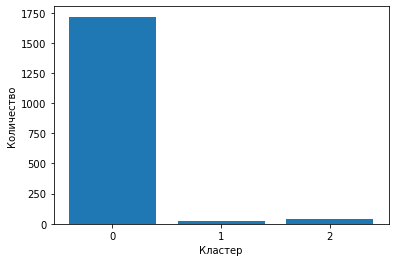

In [30]:
classes = np.bincount(preds)
plt.bar(x=[0, 1, 2], height=classes)
plt.xticks(ticks=[0, 1, 2])
plt.xlabel('Кластер')
plt.ylabel('Количество')
plt.show()

 у нас везде практически кластер 0. Есть небольшие вкрапления кластера 1, кластера 2, но не это мы ожидали в этой задаче. Давайте попробуем все же вместо частот слов использовать взвешенные частоты с помощью tf-idf векторайзеров. 

In [51]:
print(matrix[0])

  (0, 1246)	0.3906389385132699
  (0, 239)	0.09501028877632492
  (0, 1659)	0.07226670936760915
  (0, 2082)	0.09656717763921
  (0, 1846)	0.06741426312477893
  (0, 2991)	0.3895610830528872
  (0, 810)	0.0809427637021726
  (0, 2056)	0.09616720743610424
  (0, 319)	0.10054935380579341
  (0, 625)	0.05207173909126517
  (0, 3553)	0.07346689959490565
  (0, 1121)	0.06442816229222373
  (0, 838)	0.10154477899829951
  (0, 69)	0.06858267052730141
  (0, 2413)	0.10258878033617379
  (0, 3555)	0.06229087987706688
  (0, 3600)	0.05737015279917228
  (0, 2273)	0.057960021837659234
  (0, 1905)	0.08173536478989506
  (0, 3722)	0.09501028877632492
  (0, 926)	0.11742059318548873
  (0, 1991)	0.0711302768586001
  (0, 2048)	0.07488448956033757
  (0, 354)	0.06947437383545055
  (0, 900)	0.12357635170024021
  :	:
  (0, 2868)	0.08596208970791505
  (0, 855)	0.20162554088271673
  (0, 301)	0.055632566960467825
  (0, 2422)	0.09427236106959615
  (0, 3285)	0.11264581593118286
  (0, 1831)	0.1250526461821779
  (0, 620)	0.1118065

In [52]:
vectorizer.get_feature_names()

['00',
 '000',
 '01',
 '02',
 '03',
 '030',
 '0358',
 '04',
 '040',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '100',
 '1000',
 '101',
 '102',
 '104',
 '105',
 '106',
 '109',
 '11',
 '110',
 '112',
 '113',
 '119',
 '12',
 '120',
 '126',
 '127',
 '128',
 '129',
 '13',
 '132',
 '133',
 '14',
 '140',
 '15',
 '150',
 '152',
 '16',
 '160',
 '17',
 '170',
 '175',
 '18',
 '180',
 '19',
 '1987',
 '1988',
 '1989',
 '199',
 '1990',
 '1991',
 '1992',
 '1993',
 '1993apr14',
 '1993apr15',
 '1993apr16',
 '1993apr18',
 '1993apr19',
 '1993apr20',
 '1993apr5',
 '1993apr6',
 '1d17',
 '1d20',
 '1st',
 '20',
 '200',
 '2000',
 '203',
 '21',
 '210',
 '22',
 '23',
 '230',
 '24',
 '240',
 '241',
 '25',
 '253',
 '256',
 '25mhz',
 '26',
 '27',
 '28',
 '286',
 '29',
 '2nd',
 '30',
 '300',
 '30602',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '386',
 '39',
 '3rd',
 '40',
 '400',
 '403',
 '408',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '486',
 '49',
 '4mb',
 '4th',
 '50',
 '500',
 '51'

In [53]:
vectorizer.get_feature_names()[877]

'connect'

In [54]:
simple_dataset.data[0]

'From: erik@cheshire.oxy.edu (Erik Adams)\nSubject: HELP!!  My Macintosh "luggable" has lines on its screen!\nOrganization: Occidental College, Los Angeles, CA 90041 USA.\nDistribution: comp\nLines: 20\n\nOkay, I don\'t use it very much, but I would like for it to keep working\ncorrectly, at least as long as Apple continues to make System software\nthat will run on it, if slowly :-)\n\nHere is the problem:  When the screen is tilted too far back, vertical\nlines appear on the screen.  They are every 10 pixels or so, and seem\nto be affected somewhat by opening windows and pulling down menus.\nIt looks to a semi-technical person like there is a loose connection\nbetween the screen and the rest of the computer.\n\nI am open to suggestions that do not involve buying a new computer,\nor taking this one to the shop.  I would also like to not have\nto buy one of Larry Pina\'s books.  I like Larry, but I\'m not sure\nI feel strongly enough about the computer to buy a service manual\nfor it.\n

## KMeans

In [55]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3, random_state=1)
preds = model.fit_predict(matrix.toarray())
print(preds)

[0 0 2 ... 0 2 1]


In [56]:
print(simple_dataset.target)

[0 0 1 ... 0 1 2]


In [57]:
mapping = {2 : 1, 1: 2, 0: 0}
mapped_preds = [mapping[pred] for pred in preds]
print(float(sum(mapped_preds != simple_dataset.target)) / len(simple_dataset.target))

0.04727068092290377


In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
clf = LogisticRegression()
print (cross_val_score(clf, matrix, simple_dataset.target).mean())

0.9853603185880773


## Более сложная выборка

In [59]:
dataset = fetch_20newsgroups(
    subset='train', 
    categories=['comp.sys.mac.hardware', 'comp.os.ms-windows.misc', 'comp.graphics'])

In [60]:
matrix = vectorizer.fit_transform(dataset.data)
model = KMeans(n_clusters=3, random_state=42)
preds = model.fit_predict(matrix.toarray())
print(preds)
print(dataset.target)

[2 1 0 ... 2 0 2]
[2 1 1 ... 2 0 2]


In [61]:
mapping = {2 : 0, 1: 1, 0: 2}
mapped_preds = [mapping[pred] for pred in preds]
print(float(sum(mapped_preds != dataset.target)) / len(dataset.target))

0.7136337706788363


In [62]:
clf = LogisticRegression()
print(cross_val_score(clf, matrix, dataset.target).mean())

0.917279226713189


## SVD + KMeans

In [63]:
from sklearn.decomposition import TruncatedSVD

model = KMeans(n_clusters=3, random_state=42)
svd = TruncatedSVD(n_components=1000, random_state=123)
features = svd.fit_transform(matrix)
preds = model.fit_predict(features)
print(preds)
print(dataset.target)

[0 2 1 ... 0 1 0]
[2 1 1 ... 2 0 2]


In [64]:
mapping = {0 : 2, 1: 0, 2: 1}
mapped_preds = [mapping[pred] for pred in preds]
print(float(sum(mapped_preds != dataset.target)) / len(dataset.target))

0.2065031374786081


In [65]:
model = KMeans(n_clusters=3, random_state=42)
svd = TruncatedSVD(n_components=200, random_state=123)
features = svd.fit_transform(matrix)
preds = model.fit_predict(features)
print(preds)
print(dataset.target)

[2 0 1 ... 2 1 2]
[2 1 1 ... 2 0 2]


In [66]:
import itertools
def validate_with_mappings(preds, target, dataset):
    permutations = itertools.permutations([0, 1, 2])
    for a, b, c in permutations:
        mapping = {2 : a, 1: b, 0: c}
        mapped_preds = [mapping[pred] for pred in preds]
        print(float(sum(mapped_preds != target)) / len(target))
        
validate_with_mappings(preds, dataset.target, dataset)

0.9007415858528237
0.6742726754135767
0.7056474614945807
0.8938961779806047
0.2053622361665716
0.6200798630918426


In [67]:
model = KMeans(n_clusters=3, random_state=42)
svd = TruncatedSVD(n_components=200, random_state=321)
features = svd.fit_transform(matrix)
preds = model.fit_predict(features)
print(preds)
print(dataset.target)
validate_with_mappings(preds, dataset.target, dataset)

[2 1 0 ... 2 0 2]
[2 1 1 ... 2 0 2]
0.713063320022818
0.845407872219053
0.8893325727324587
0.7005134055904164
0.5864232743867656
0.2652595550484883


## Итоги

1. Получили интерпретируемый результат на обеих выборках
1. Реальность, однако, намного более жестока
1. Попробовали использовать AgglomerativeClustering и KMeans